In [1]:
import sys

import beakerx
import ipywidgets
from IPython.display import display, HTML
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sys.path.append('../..')

from solution import solarpvutil

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

scenario_choices = ipywidgets.SelectMultiple(
    options=solarpvutil.scenarios,
    description='Scenarios',
    disabled=False, rows=8
)
scenario_choices

SelectMultiple(description='Scenarios', options=('PDS3-16p2050-Optimum (Updated)', 'PDS2-15p2050-Drawdown (Upd…

Scenario,Implementation Unit Adoption Increase in 2050 (PDS vs REF),Functional Unit Adoption Increase in 2050 (PDS vs REF)
PDS3-16p2050-Optimum (Updated),4.116,7895.386
,TW,TWh


Scenario,Global Solution Implementation Units in 2050,Global Solution Functional Units in 2050,Global Solution Adoption Share - 2014,Global Solution Adoption Share - 2020,Global Solution Adoption Share - 2050
PDS3-16p2050-Optimum (Updated),4.26,8167.80,,,
,TW,TWh,%,%,%


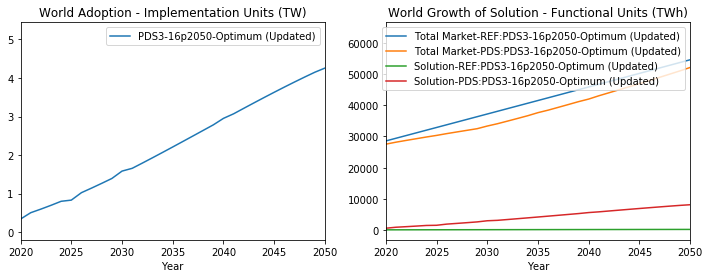

Scenario,Marginal First Cost 2020-2050,Net Operating Savings 2020-2050,Lifetime Operating Savings 2020-2050
PDS3-16p2050-Optimum (Updated),-305.15,11346.96,21276.66
,Billion USD,Billion USD,Billion USD


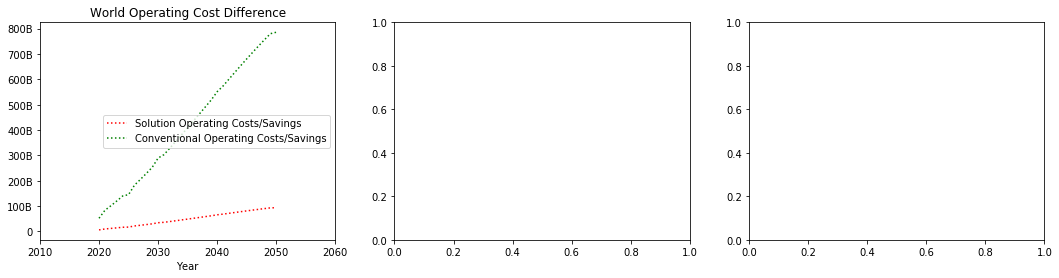

Scenario,Total Emissions Reduction
PDS3-16p2050-Optimum (Updated),62.53
,Gt CO2 (2020-2050)


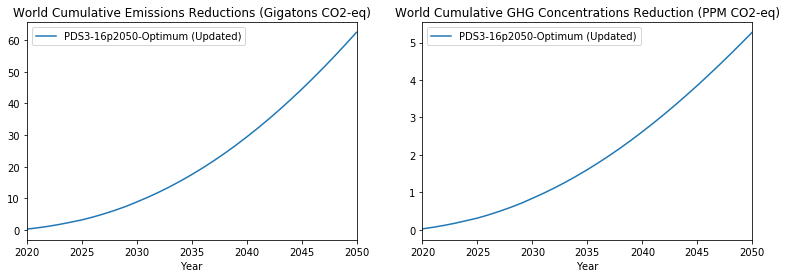

,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5, Coal - PC, min (Table A.III.1)",World,,2014,380,US$2010/kW,@energy_mix_coal@
1,"IPCC WG3 AR5, Coal - PC, max (Table A.III.1)",World,,2014,3900,US$2010/kW,@energy_mix_coal@
2,"IPCC WG3 AR5, Natural Gas - CCGT, min (Table ...",World,,2014,550,US$2010/kW,@energy_mix_natural_gas@
3,"IPCC WG3 AR5, Natural Gas - CCGT, max (Table ...",World,,2014,2100,US$2010/kW,@energy_mix_natural_gas@
4,"Lazard's LCOE Analysis–Version 10.0, 2016, coa...",USA,,2016,3000,US$2016/kW,@energy_mix_coal@
5,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,1000,US$2016/kW,@energy_mix_natural_gas@
6,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,1300,US$2016/kW,@energy_mix_natural_gas@
7,"Lazard's LCOE Analysis–Version 10.0, 2016, Die...",USA,,2016,500,US$2016/kW,@energy_mix_oil@
8,"Lazard's LCOE Analysis–Version 10.0, 2016, Die...",USA,,2016,800,US$2016/kW,@energy_mix_oil@
9,IEA (2010) Projected Costs of generating Elect...,Middle East and Africa,South Africa,2010,461,US$2010/kW,@energy_mix_oil@


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,REN21 2015 - World,World,,2015,2100,US$2014/kW,
1,REN21 2015 - China,China,,2015,1670,US$2014/kW,
2,REN21 2015 - Japan,OECD90,Japan,2015,2710,US$2014/kW,
3,REN21 2015 - Germany,EU,Germany,2015,1495,US$2014/kW,
4,REN21 2015 - UK,EU,UK,2015,2080,US$2014/kW,
5,REN21 2015 - USA,USA,,2015,2218,US$2014/kW,
6,"IRENA 2015 - Africa (Figure 5.14, p. 92)",Middle East and Africa,,2015,3151,US$2014/kW,
7,"IRENA 2015 - China (Figure 5.14, p. 92)",China,,2015,1672,US$2014/kW,
8,"IRENA 2015 - Europe (Figure 5.14, p. 92)",EU,,2015,1672,US$2014/kW,
9,IRENA 2015 - Central and South America (Figure...,Latin America,,2015,2318,US$2014/kW,


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5, Coal (Table A.III.1)",World,,2014,40,years,@energy_mix_coal@
1,"IPCC WG3 AR5, Natural Gas (Table A.III.1)",World,,2014,30,years,@energy_mix_natural_gas@
2,"IEA Technology Roadmap 2012, Coal",World,,2012,50,years,@energy_mix_coal@
3,"IEA, ETSAP, 2010, Natural Gas",World,,2010,30,years,@energy_mix_natural_gas@
4,"Lazard's LCOE Analysis–Version 10.0, 2016, coal",USA,,2016,40,years,@energy_mix_coal@
5,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,20,years,@energy_mix_natural_gas@
6,"Lazard's LCOE Analysis–Version 10.0, 2016, Die...",USA,,2016,20,years,@energy_mix_oil@
7,"Schmidt T. S., R. Born, and M. Schneider (2012...",World,,2012,25,years,@energy_mix_natural_gas@
8,"Schmidt T. S., R. Born, and M. Schneider (2012...",World,,2012,40,years,@energy_mix_coal@
9,"Schmidt T. S., R. Born, and M. Schneider (2012...",World,,2012,25,years,@energy_mix_oil@


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,IPCC WG3 AR5 (Table A.III.1) Solar PV,World,,2014,25,years,
1,"ITRPV, 2016 (p. 40)",World,,2016,25,years,
2,IEA Roadmap 2014,World,,2014,25,years,
3,"Lazard's LCOE Analysis–Version 10.0, 2016, uti...",USA,,2015,30,years,


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"EIA 2016, Electric Power Monthly, Coal (2013) ...",USA,,2016,59.7%,Capacity factor (%),@energy_mix_coal@
1,"EIA 2016, Electric Power Monthly, Coal (2014) ...",USA,,2016,61.0%,Capacity factor (%),@energy_mix_coal@
2,"EIA 2016, Electric Power Monthly, Coal (2015) ...",USA,,2016,54.6%,Capacity factor (%),@energy_mix_coal@
3,"EIA 2016, Electric Power Monthly, Natural Gas ...",USA,,2016,48.2%,Capacity factor (%),@energy_mix_natural_gas@
4,"EIA 2016, Electric Power Monthly, Natural Gas ...",USA,,2016,48.3%,Capacity factor (%),@energy_mix_natural_gas@
5,"EIA 2016, Electric Power Monthly, Natural Gas ...",USA,,2016,56.3%,Capacity factor (%),@energy_mix_natural_gas@
6,"IEA ETP 2016, Natural Gas (in 2013) (Ch. 2 Fi...",OECD90,Australia,2016,35.41%,Capacity factor (%),@energy_mix_natural_gas@
7,"IEA ETP 2016, Natural Gas (in 2013) (Ch. 2 Fi...",USA,,2016,31.087%,Capacity factor (%),@energy_mix_natural_gas@
8,"IEA ETP 2016, Natural Gas (in 2013) (Ch. 2 Fi...",EU,Portugal,2016,17.84%,Capacity factor (%),@energy_mix_natural_gas@
9,"IEA ETP 2016, Natural Gas (in 2013) (Ch. 2 Fi...",OECD90,Japan,2016,98.239%,Capacity factor (%),@energy_mix_natural_gas@


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5 (Table A.III.1) Solar PV, min",World,,2014,1200,kWh/kW,
1,"IPCC WG3 AR5 (Table A.III.1) Solar PV, max",World,,2014,2400,kWh/kW,
2,"REN21 2016, Africa, weighted average",Middle East and Africa,Africa,2016,19.90%,Capacity factor (%),
3,"REN21 2016, Asia, weighted average",Asia (Sans Japan),Asia,2016,16.60%,Capacity factor (%),
4,"REN21 2016, Central America and the Caribbean,...",Latin America,Central America and the Caribbean,2016,19.80%,Capacity factor (%),
5,"REN21 2016, Eurasia, weighted average",Asia (Sans Japan),Eurasia,2016,11.90%,Capacity factor (%),
6,"REN21 2016, Europe, weighted average",EU,Europe,2016,12.30%,Capacity factor (%),
7,"REN21 2016, Middle East, weighted average",Middle East and Africa,Middle East,2016,25.60%,Capacity factor (%),
8,"REN21 2016, South America, weighted average",Latin America,South America,2016,32.00%,Capacity factor (%),
9,"REN21 2016, China, weighted average",China,China,2016,17.00%,Capacity factor (%),


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5, Coal - PC, min (Table A.III.1)",World,,2014,0.00,US$2010/MWh,@energy_mix_coal@
1,"IPCC WG3 AR5, Coal - PC, max (Table A.III.1)",World,,2014,9.00,US$2010/MWh,@energy_mix_coal@
2,"IPCC WG3 AR5, Natural Gas - CCGT, min (Table ...",World,,2014,0.00,US$2010/MWh,@energy_mix_natural_gas@
3,"IPCC WG3 AR5, Natural Gas - CCGT, max (Table ...",World,,2014,4.90,US$2010/MWh,@energy_mix_natural_gas@
4,"Lazard's LCOE Analysis–Version 10.0, 2016, coa...",USA,,2016,2.00,US$2016/MWh,@energy_mix_coal@
5,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,2.00,US$2016/MWh,@energy_mix_natural_gas@
6,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,3.50,US$2016/MWh,@energy_mix_natural_gas@
7,"Lazard's LCOE Analysis–Version 10.0, 2016, die...",USA,,2016,15.00,US$2016/MWh,@energy_mix_oil@
8,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,4.50,US$2016/MWh,@energy_mix_natural_gas@
9,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,7.50,US$2016/MWh,@energy_mix_natural_gas@


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5, Coal - PC, min (Table A.III.2)",World,,2014,0.00,US$2010/kW,@energy_mix_coal@
1,"IPCC WG3 AR5, Coal - PC, max (Table A.III.2)",World,,2014,75.00,US$2010/kW,@energy_mix_coal@
2,"IPCC WG3 AR5, Natural Gas - CCGT, min (Table ...",World,,2014,0.00,US$2010/kW,@energy_mix_natural_gas@
3,"IPCC WG3 AR5, Natural Gas - CCGT, max (Table...",World,,2014,39.00,US$2010/kW,@energy_mix_natural_gas@
4,"Lazard's LCOE Analysis–Version 10.0, coal, low...",USA,,2016,40.00,US$2016/kW,@energy_mix_coal@
5,"Lazard's LCOE Analysis–Version 10.0, gas CC, h...",USA,,2016,5.50,US$2016/kW,@energy_mix_natural_gas@
6,"Lazard's LCOE Analysis–Version 10.0, gas CC, l...",USA,,2016,6.20,US$2016/kW,@energy_mix_natural_gas@
7,"Lazard's LCOE Analysis–Version 10.0, diesel re...",USA,,2016,15.00,US$2016/kW,@energy_mix_oil@
8,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,5.00,US$2016/kW,@energy_mix_natural_gas@
9,"Lazard's LCOE Analysis–Version 10.0, 2016, nat...",USA,,2016,25.00,US$2016/kW,@energy_mix_natural_gas@


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,IPCC WG3 AR5 (Table A.III.1) Solar PV–utility,World,,2014,20.0000,US$2010/kW,
1,"Bolinger and Seel, 2015 (LBNL) (pp. 20-21)",USA,,2015,0.0078,US$2014/kWh,
2,"Rhyne, I., Klein, J. (2014). Estimated Cost of...",USA,,2014,17.9700,US$2013/kW,
3,"Rhyne, I., Klein, J. (2014). Estimated Cost of...",USA,,2014,28.5500,US$2013/kW,
4,"Rhyne, I., Klein, J. (2014). Estimated Cost of...",USA,,2014,52.8600,US$2013/kW,
5,"U.S. EIA, 2013, 150 MW",USA,,2013,24.6900,US$2012/kW,
6,"U.S. EIA, 2013, 20 MW",USA,,2013,27.7500,US$2012/kW,
7,"U.S. DOE SunShot Vision Study, 2012, Ch. 4",USA,,2012,19.9300,US$2010/kW,
8,"NREL Annual Technology Baseline, 2015, utility PV",USA,,2015,18.0000,US$2014/kW,
9,"IEA 2012 ETP, utility-scale",World,,2012,40.0000,US$2010/kW,


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"Average of Thin-film a-Si, ground mount",World,Various,Various,38.250000,g-CO2eq/kWh,4.50%
1,"Average of Thin-film CdTe, ground-mount",World,Various,Various,22.750000,g-CO2eq/kWh,0.50%
2,"Average of Thin-film CIGS, ground-mount",World,Various,Various,50.933333,g-CO2eq/kWh,2.00%
3,"Average of Monocrystalline-Si, ground-mount",World,Various,Various,50.300000,g-CO2eq/kWh,24.00%
4,"Average of Multicrystalline-Si, ground mount",World,Various,Various,54.710000,g-CO2eq/kWh,69.00%
5,"Masanet, E., Chang, Y., Gopal, A.R., Larsen, P...",World,,2013,217.000000,g-CO2eq/kWh,100.00%
6,"Masanet, E., Chang, Y., Gopal, A.R., Larsen, P...",World,,2013,5.000000,g-CO2eq/kWh,100.00%


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,From coal_plant_efficiency_vma variable,World,,Various,37.1577551412647%,%,@energy_mix_coal@
1,From natural_gas_plant_efficiency_vma variable,World,,Various,48.2936717783726%,%,@energy_mix_natural_gas@
2,From oil_plant_efficiency_vma variable,OECD90,Japan,2005,39%,%,4.736499192%


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5, min (Table A.III.2)",World,,2014,33%,%,
1,"IPCC WG3 AR5, max (Table A.III.2)",World,,2014,48%,%,
2,"IEA 2010, Power Generation from Coal (p. 61), ...",World,,2010,33%,%,
3,"US EIA, Average 2004-2014",USA,,2015,10406,BTU/kWh,


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,"IPCC WG3 AR5, min (Table A.III.2)",World,,2014,41%,%,
1,"IPCC WG3 AR5, max (Table A.III.2)",World,,2014,60%,%,
2,"IEA 2010, ETSAP, OCGT, lower heating value, min",World,,2010,35%,%,
3,"IEA 2010, ETSAP, OCGT, lower heating value, max",World,,2010,42%,%,
4,"IEA 2010, ETSAP, CCGT, lower heating value, min",World,,2010,52%,%,
5,"IEA 2010, ETSAP, CCGT, lower heating value, max",World,,2010,60%,%,
6,"US EIA, Average 2004-2014",World,,2015,8251.636364,Btu/kWh,


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,Hondo (2005) Oil fired powerplant,OECD90,Japan,2005,39%,%,


,Source ID,Region,Specific Geographic Location,Year,Raw Data Input,Original Units,Weight
0,GTM Research 2014,USA,,2014,63.0%,%,
1,IEA Technology Roadmap 2014,World,,2014,50.0%,%,
2,"US DOE, SunShot Vision Study, 2012, Ch. 3 (p. 43)",USA,,2012,66.6666666666667%,%,


,soln_pds_annual_operating_cost,conv_ref_annual_operating_cost,marginal_annual_operating_cost
Year,,,
2015,7.164091e+08,5.998216e+09,5.281807e+09
2016,1.822476e+09,1.525889e+10,1.343641e+10
2017,3.116062e+09,2.608958e+10,2.297352e+10
2018,4.588748e+09,3.841981e+10,3.383106e+10
2019,6.232112e+09,5.217906e+10,4.594695e+10
2020,6.232298e+09,5.218062e+10,4.594832e+10
2021,9.997197e+09,8.370265e+10,7.370545e+10
2022,1.210208e+10,1.013260e+11,8.922391e+10
2023,1.434395e+10,1.200964e+11,1.057524e+11


,soln_pds_install_cost_per_iunit,soln_ref_install_cost_per_iunit,conv_ref_install_cost_per_iunit
Year,,,
2014,1.646198e+12,1.461297e+12,2.010032e+12
2015,1.444940e+12,1.444940e+12,2.005750e+12
2016,1.273339e+12,1.429364e+12,2.003710e+12
2017,1.152304e+12,1.414506e+12,2.001741e+12
2018,1.060716e+12,1.400310e+12,1.999838e+12
2019,9.882146e+11,1.386724e+12,1.997998e+12
2020,9.862498e+11,1.373704e+12,1.996215e+12
2021,8.794379e+11,1.361208e+12,1.994488e+12
2022,8.372403e+11,1.349202e+12,1.992811e+12


In [2]:
#%%prun -s cumulative -l 200
if len(scenario_choices.value):
    spv = [solarpvutil.SolarPVUtil(v) for v in scenario_choices.value]
else:
    spv = [solarpvutil.SolarPVUtil()]

display(HTML('<h2>' + str(spv[0].name) + '</h2>'))

# ------------------ Detailed Results -----------------

def blue_label(text):
    o = ipywidgets.Output()
    div = '<div style="background-color:LightSkyBlue;border:1px solid black;font-weight:bold;text-align:center;font-size:0.875em;">'
    with o:
        display(HTML(div + text + '</div>'))
    return o


key_results_label = blue_label('The Key Adoption Results')

# --- Unit Adoption ---

unit_adoption_text = []
for s in spv:
    pds_vs_ref = s.ua.soln_pds_tot_iunits_reqd().loc[2050, 'World'] - s.ua.soln_ref_tot_iunits_reqd().loc[2050, 'World']
    unit_adoption_text.append([s.scenario, pds_vs_ref, s.ua.soln_net_annual_funits_adopted().loc[2050, 'World'] ])
unit_adoption_text.append(['', 'TW', 'TWh'])
unit_adoption_columns = ['Scenario', 'Implementation Unit Adoption Increase in 2050 (PDS vs REF)',
                         'Functional Unit Adoption Increase in 2050 (PDS vs REF)']
unit_adoption_heading = ipywidgets.Output()
with unit_adoption_heading:
    display(HTML(pd.DataFrame(unit_adoption_text, columns=unit_adoption_columns).to_html(index=False, float_format=lambda x: '%.3f' % x)))

# --- Adoption ---

adoption_text = []
for s in spv:
    adoption_text.append([s.scenario,
                          s.ua.soln_pds_tot_iunits_reqd().loc[2050, 'World'],
                          s.ht.soln_pds_funits_adopted().loc[2050, 'World'],
                          '', '', ''])
adoption_text.append(['', 'TW', 'TWh', '%', '%', '%'])
adoption_columns = ['Scenario', 'Global Solution Implementation Units in 2050',
                    'Global Solution Functional Units in 2050', 'Global Solution Adoption Share - 2014',
                    'Global Solution Adoption Share - 2020', 'Global Solution Adoption Share - 2050']
adoption_heading = ipywidgets.Output()
with adoption_heading:
    display(HTML(pd.DataFrame(adoption_text, columns=adoption_columns).to_html(index=False, float_format=lambda x: '%.2f' % x)))

adoption_graphs = ipywidgets.Output()
with adoption_graphs:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax[0].set_title('World Adoption - Implementation Units (TW)')
    for s in spv:
        s.ua.soln_pds_tot_iunits_reqd()['World'].plot(ax=ax[0], legend=True, label=s.scenario, xlim=(2020, 2050))
    ax[1].set_title('World Growth of Solution - Functional Units (TWh)')
    for s in spv:
        s.tm.ref_tam_per_region()['World'].plot(ax=ax[1], legend=True, label='Total Market-REF:'+s.scenario, xlim=(2020, 2050))
        s.tm.pds_tam_per_region()['World'].plot(ax=ax[1], legend=True, label='Total Market-PDS:'+s.scenario, xlim=(2020, 2050))
        s.ht.soln_ref_funits_adopted()['World'].plot(ax=ax[1], legend=True, label='Solution-REF:'+s.scenario, xlim=(2020, 2050))
        s.ht.soln_pds_funits_adopted()['World'].plot(ax=ax[1], legend=True, label='Solution-PDS:'+s.scenario, xlim=(2020, 2050))
    plt.show(fig)

# --- Financial ---

financial_results_label = blue_label('The Key Financial Results</div>')

financial_text = []
for s in spv:
    marginal_first_cost = (s.fc.soln_pds_annual_world_first_cost().loc[:2050].sum() - \
        s.fc.soln_ref_annual_world_first_cost().loc[:2050].sum() - \
        s.fc.conv_ref_annual_world_first_cost().loc[:2050].sum()) / 10**9
    net_operating_savings = ((s.oc.conv_ref_cumulative_operating_cost().loc[2050] - \
                             s.oc.conv_ref_cumulative_operating_cost().loc[2020]) - \
                            (s.oc.soln_pds_cumulative_operating_cost().loc[2050] - \
                             s.oc.soln_pds_cumulative_operating_cost().loc[2020])) / 10**9
    lifetime_operating_savings = s.oc.lifetime_cost_forecast()['Marginal Operating Cost Savings'].sum() / 10**9
    financial_text.append([s.scenario, marginal_first_cost, net_operating_savings, lifetime_operating_savings])
financial_text.append(['', 'Billion USD', 'Billion USD', 'Billion USD'])
financial_columns = ['Scenario', 'Marginal First Cost 2020-2050',
                     'Net Operating Savings 2020-2050', 'Lifetime Operating Savings 2020-2050']

financial_heading = ipywidgets.Output()
with financial_heading:
    display(HTML(pd.DataFrame(financial_text, columns=financial_columns).to_html(index=False, float_format=lambda x: '%.2f' % x)))

cost_graphs = ipywidgets.Output()
with cost_graphs:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    ax[0].set_title('World Operating Cost Difference')
    ax[0].set_xlim(left=2010, right=2060)
    ax[0].set_xlabel('Billions US$2014')
    matplotlib.ticker.EngFormatter.ENG_PREFIXES[9] = 'B'
    fmty = matplotlib.ticker.EngFormatter(sep='')
    ax[0].yaxis.set_major_formatter(fmty)
    for s in spv:
        linestyle = '--' if 'Plausible' in s.scenario else '-.' if 'Drawdown' in s.scenario else ':'
        s.oc.soln_pds_annual_operating_cost().loc[2020:2050].plot(ax=ax[0], legend=True, linestyle=linestyle, color='r', label='Solution Operating Costs/Savings')
        s.oc.conv_ref_annual_operating_cost().loc[2020:2050].plot(ax=ax[0], legend=True, linestyle=linestyle, color='g', label='Conventional Operating Costs/Savings')
    plt.show(fig)

# --- Climate ---

climate_results_label = blue_label('The Key Climate Results</div>')

climate_text = []
for s in spv:
    climate_text.append([s.scenario, (s.c2.co2eq_mmt_reduced().loc[:, 'World'].sum() / 1000)])
climate_text.append(['', 'Gt CO2 (2020-2050)'])
climate_columns = ['Scenario', 'Total Emissions Reduction']

climate_heading = ipywidgets.Output()
with climate_heading:
    display(HTML(pd.DataFrame(climate_text, columns=climate_columns).to_html(index=False, float_format=lambda x: '%.2f' % x)))

emissions_graphs = ipywidgets.Output()
with emissions_graphs:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
    ax[0].set_title('World Cumulative Emissions Reductions (Gigatons CO2-eq)')
    ax[0].set_xlim(left=2020, right=2050)
    for s in spv:
        s.c2.co2eq_mmt_reduced()['World'].cumsum().mul(0.001).plot(ax=ax[0], legend=True, label=s.scenario)
    ax[1].set_title('World Cumulative GHG Concentrations Reduction (PPM CO2-eq)')
    ax[1].set_xlim(left=2020, right=2050)
    for s in spv:
        s.c2.co2eq_ppm_calculator()['CO2-eq PPM'].plot(ax=ax[1], legend=True, label=s.scenario)
    plt.show(fig)

detailed_results = ipywidgets.Output()
with detailed_results:
    display(ipywidgets.VBox([key_results_label, unit_adoption_heading, adoption_heading, adoption_graphs,
                             financial_results_label, financial_heading, cost_graphs,
                             climate_results_label, climate_heading, emissions_graphs]))

# --------------- Variable Meta Analysis --------------

variable_meta_analysis = ipywidgets.Output()
with variable_meta_analysis:
    children = []
    for s in spv:
        for (name, v) in s.VMAs:
            vma_widget = ipywidgets.Output()
            with vma_widget:
                display(HTML(v.source_data.drop(['Link', 'Source Validation Code', 'License Code'], axis=1).fillna('').to_html()))
            accordion = ipywidgets.Accordion(children=[vma_widget])
            accordion.set_title(0, name)
            vma_widget = ipywidgets.Output()
            with vma_widget:
                display(ipywidgets.HBox(children=[ipywidgets.Label('Summary Placeholder'), accordion]))
            children.append(vma_widget)
    display(ipywidgets.VBox(children=children))

# ------------------ Operating Cost -----------------

children = []
for s in spv:
    df = pd.concat([s.oc.soln_pds_annual_operating_cost().loc[:2060],
                    s.oc.conv_ref_annual_operating_cost().loc[:2060],
                    s.oc.marginal_annual_operating_cost().loc[:2060]],
                   axis=1)
    oc_table = ipywidgets.Output()
    with oc_table:
        display(HTML(df.to_html()))
    children.append(oc_table)

operating_cost = ipywidgets.Accordion(children=children)
for i, s in enumerate(spv):
    operating_cost.set_title(i, s.scenario)

# ------------------ First Cost -----------------

children = []
for s in spv:
    df = pd.concat([s.fc.soln_pds_install_cost_per_iunit().loc[:2060],
                    s.fc.soln_ref_install_cost_per_iunit().loc[:2060],
                    s.fc.conv_ref_install_cost_per_iunit().loc[:2060]],
                   axis=1)
    fc_table = ipywidgets.Output()
    with fc_table:
        display(HTML(df.to_html()))
    children.append(fc_table)

first_cost = ipywidgets.Accordion(children=children)
for i, s in enumerate(spv):
    first_cost.set_title(i, s.scenario)

# ------------------ Create tabs -----------------

tabs = ipywidgets.Tab(children=[detailed_results, variable_meta_analysis, operating_cost, first_cost])
tabs.set_title(0, "Detailed Results")
tabs.set_title(1, "Variable Meta-Analysis")
tabs.set_title(2, "Operating Cost")
tabs.set_title(3, "First Cost")
display(tabs)